In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) #This is to eliminate the warning which results from training 1 epoch at a time

In [2]:
data1 = pd.read_csv("data1.csv") #uses pandas to read the csv data file into a dataframe named data1

In [3]:
print(data1.head()) #displays the first 5 rows of data1

     X1         X2   X3  X4     Y
0  32.0   84.87882  2.0  10  37.9
1  19.5  306.59470  2.5   9  42.2
2  13.3  561.98450  3.3   5  47.3
3  13.3  561.98450  2.1   5  54.8
4   5.0  390.56840  0.8   5  43.1


In [4]:
X = data1[["X1", "X2", "X3", "X4"]] #separates the predictor variables (first four columns) from the data, this is a dataframe

In [5]:
Y = data1["Y"] #separates the response variable from the data, also used single brackets to make it a series, may need to revisit this

In [6]:
scale = MinMaxScaler() #minmax scaler from scikit learn

In [7]:
X_prime = scale.fit_transform(X) #applies min-max scale to predictor variables: (x-min(x))/(max(x)-min(x))

In [8]:
X_prime_df = pd.DataFrame(X_prime, columns=X.columns) #puts the scaled predictor variables into a dataframe

In [9]:
print(X_prime_df.head()) #displays first 5 rows of the scaled predictors

         X1        X2     X3   X4
0  0.730594  0.009513  0.500  1.0
1  0.445205  0.043809  0.625  0.9
2  0.303653  0.083315  0.825  0.5
3  0.303653  0.083315  0.525  0.5
4  0.114155  0.056799  0.200  0.5


In [10]:
#each linear regression model will use a subset from the scaled predictors regressed on the response Y, this is a list of the column names that will be used from the scaled predictors
predictor_subsets = [
    ['X1'],
    ['X2'],
    ['X3'],
    ['X4'],
    ['X1', 'X2'],
    ['X1', 'X3'],
    ['X1', 'X4'],
    ['X2', 'X3'],
    ['X2', 'X4'],
    ['X3', 'X4'],
    ['X1', 'X2', 'X3'],
    ['X1', 'X2', 'X4'],
    ['X1', 'X3', 'X4'],
    ['X2', 'X3', 'X4'],
    ['X1', 'X2', 'X3', 'X4']
]

In [11]:
#Defining the folds in a dictionary, the keys are the names and the values are what they are defined as, ranges are from the assignment document
folds = { 
    "fold_1": {"train": list(range(0, 210)), "val": list(range(210, 280)), "test": list(range(280, 400))}, 
    "fold_2": {"train": list(range(70, 280)), "val": list(range(210, 350)), "test": list(range(0, 70))}, 
    "fold_3": {"train": list(range(0, 210)), "val": list(range(210, 280)), "test": list(range(280, 400))}, 
    "fold_4": {"train": list(range(0, 210)), "val": list(range(210, 280)), "test": list(range(280, 400))}, 
    "fold_5": {"train": list(range(0, 210)), "val": list(range(210, 280)), "test": list(range(280, 400))}, 
}

In [12]:
learning_rate = 0.01 #learning rate set at 0.01
max_epochs = 1000 #one stopping condition for training "maximum of 1000 gradient descent iterations (or epochs)"
sc_2 = 10 #early/second stopping condition for training "cost function stops improving for 10 iterations in a row on the early stopping set"

In [13]:
results = {} #dictionary to store validation MSE and test MSE for each model
results2 = {} #dictionary for various MSE measures
model_objects = {} #dictionary to store model objects, will call best model from here

In [14]:
for i, subset in enumerate(predictor_subsets, start=1): #this loop will run through each of the predictor column names defined above using the enumerate function to start at 1
    results[f'lm_{i}'] = {} #creates a dictionary to store test MSE for each model, f-string to reference variable linear model_i (i =1,...,15)
    results2[f'lm_{i}'] = {} #this will be used to store training mse, validation mse, and test mse for each epoch to use for deliverable 2
    model_objects[f'lm_{i}'] = {} #used for storing model objects for each model
    for fold_name, indices in folds.items(): #this loop will run through the folds defined above for each model
        num_rows = X_prime_df.shape[0] #this will be able to adjust from using 350 observations to the 400 observations in the test set, .shape returns (rows, columns) and indexing with 0 grabs number of rows
        X_train = X_prime_df.iloc[[j for j in indices["train"] if j < num_rows]][subset] #iloc grabs rows in X_prime_df for "train" in the fold which is less than num_rows for the specified subset 
        X_val = X_prime_df.iloc[[j for j in indices["val"] if j < num_rows]][subset] #iloc grabs rows in X_prime_df for "val" in the fold which is less than num_rows for the specified subset 
        X_test =  X_prime_df.iloc[[j for j in indices["test"] if j < num_rows]][subset] #iloc grabs rows in X_prime_df for "test" in the fold which is less than num_rows for the specified subset 
        Y_train = Y.iloc[[j for j in indices["train"] if j < num_rows]] #iloc grabs rows in Y for "train" in the fold which is less than num_rows
        Y_val = Y.iloc[[j for j in indices["val"] if j < num_rows]] #iloc grabs rows in Y for "val" in the fold which is less than num_rows
        Y_test =  Y.iloc[[j for j in indices["test"] if j < num_rows]] #iloc grabs rows in Y for "test" in the fold which is less than num_rows
        model = SGDRegressor(learning_rate='constant', eta0=learning_rate, max_iter=1, warm_start=True) #uses SGDRegressor to create a model with arguments learning_rate set at 'constant', eta0=learning_rate starts it at .01, max_iter makes the model train 1 epoch at a time, warm_start=True lets the model continue training from the previous state
        best_val_mse = float('inf') #initializes the lowest validation MSE to infinity and is adjusted as the model improves
        no_improvement_count = 0 #tracks how many epochs the validation error fails to improve for the early stopping condition (sc_2 = 10)
        results2[f'lm_{i}'][fold_name] = {
            'train_mse': [],
            'val_mse': [],
            'test_mse': []
        } #initializes list of items to be stored for each epoch 
        
        for epoch in range(max_epochs): #this loop creates the models 1 epoch at a time with a max of 1000 epochs and checking for the early/second stopping condition
            model.fit(X_train, Y_train) #creates model using training data for 1 epoch at a time
            Y_train_pred = model.predict(X_train) #creates prediction data using training data
            train_mse = mean_squared_error(Y_train, Y_train_pred) #MSE for training data
            Y_val_pred = model.predict(X_val) #creates prediction data using validation data
            val_mse = mean_squared_error(Y_val, Y_val_pred) #MSE for validation data
            Y_test_pred_1 = model.predict(X_test) #creates prediction data using test data 
            test_mse_1 = mean_squared_error(Y_test, Y_test_pred_1) #per epoch MSE for test data
            results2[f'lm_{i}'][fold_name]['train_mse'].append(train_mse) #appends train_mse for current epoch to results2
            results2[f'lm_{i}'][fold_name]['val_mse'].append(val_mse) #appends val_mse for current epoch to results2
            results2[f'lm_{i}'][fold_name]['test_mse'].append(test_mse_1) #appends _mse for current epoch to results2
            model_objects[f'lm_{i}'][fold_name] = model
            if val_mse < best_val_mse: #this will check for the early stopping condition checks to see if calculated mse < best_val_mse
                best_val_mse = val_mse #sets current best mse at previous calculated mse if < condition confirmed
                no_improvement_count = 0 #sets improvement counter to 0 because it just changed
            else:  #if < condition doesn't pass
                no_improvement_count += 1 #improvement counter increased by 1
            if no_improvement_count >= sc_2: #checks to see if improvement counter >= the early/second stopping condition of 10
                print(f"Early stopping at epoch {epoch+1} for Model {i} in {fold_name}") #prints early stopping message with epoch number of early stopping for which model and fold
                break #breaks out of loop
        Y_test_pred = model.predict(X_test) #creates prediction data using test data 
        test_mse = mean_squared_error(Y_test, Y_test_pred) #final MSE for test data
        results[f'lm_{i}'][fold_name] = {'test_mse': test_mse} #stores test mse results for current model and fold in the results dictionary as another dictionary
        print(f"Model {i} - {fold_name} - Test MSE: {test_mse:.4f}") #prints model number, fold, and test MSE floating point number with 4 decimal places, used to manually check average test mse
    

Early stopping at epoch 32 for Model 1 in fold_1
Model 1 - fold_1 - Test MSE: 157.4580
Early stopping at epoch 32 for Model 1 in fold_2
Model 1 - fold_2 - Test MSE: 161.6086
Early stopping at epoch 28 for Model 1 in fold_3
Model 1 - fold_3 - Test MSE: 156.3984
Early stopping at epoch 30 for Model 1 in fold_4
Model 1 - fold_4 - Test MSE: 156.8627
Early stopping at epoch 28 for Model 1 in fold_5
Model 1 - fold_5 - Test MSE: 156.1309
Early stopping at epoch 47 for Model 2 in fold_1
Model 2 - fold_1 - Test MSE: 91.0239
Early stopping at epoch 46 for Model 2 in fold_2
Model 2 - fold_2 - Test MSE: 86.6711
Early stopping at epoch 43 for Model 2 in fold_3
Model 2 - fold_3 - Test MSE: 90.9394
Early stopping at epoch 47 for Model 2 in fold_4
Model 2 - fold_4 - Test MSE: 92.9812
Early stopping at epoch 43 for Model 2 in fold_5
Model 2 - fold_5 - Test MSE: 94.8777
Early stopping at epoch 22 for Model 3 in fold_1
Model 3 - fold_1 - Test MSE: 167.4148
Early stopping at epoch 48 for Model 3 in fold_2

In [15]:
#best five models based on average test MSE
average_test_mse = {} #dictionary for average test MSE for each model

for model_key, folds_data in results.items(): #this will loop over each model in the results dictionary above which contained the keys (e.g. lm_1) and the value for each key which contained fold info
    mse_values = [fold_data['test_mse'] for fold_data in folds_data.values()] #collects test MSE for each fold for the model
    average_test_mse[model_key] = np.mean(mse_values) #calculate the mean test MSE over the five folds for the model and places in dictionary

sorted_models = sorted(average_test_mse.items(), key=lambda x: x[1]) #turns average_test_MSE dictionary into tuples of (model,avg_test_MSE) and then sorts based on avg_test_MSE, stores in sorted_models
best_five = sorted_models[:5] #gets the best five models ('best' means lowest average test MSE)
print("Best Five Models based on Average Test MSE:")
for model, avg_mse in best_five:
    print(f"{model}: Average Test MSE is {avg_mse:.2f}") #f-string to use variables from best_five, model and avg_mse (floating point number rounded to two places)

Best Five Models based on Average Test MSE:
lm_15: Average Test MSE is 76.75
lm_14: Average Test MSE is 77.02
lm_12: Average Test MSE is 78.09
lm_9: Average Test MSE is 78.21
lm_11: Average Test MSE is 86.63


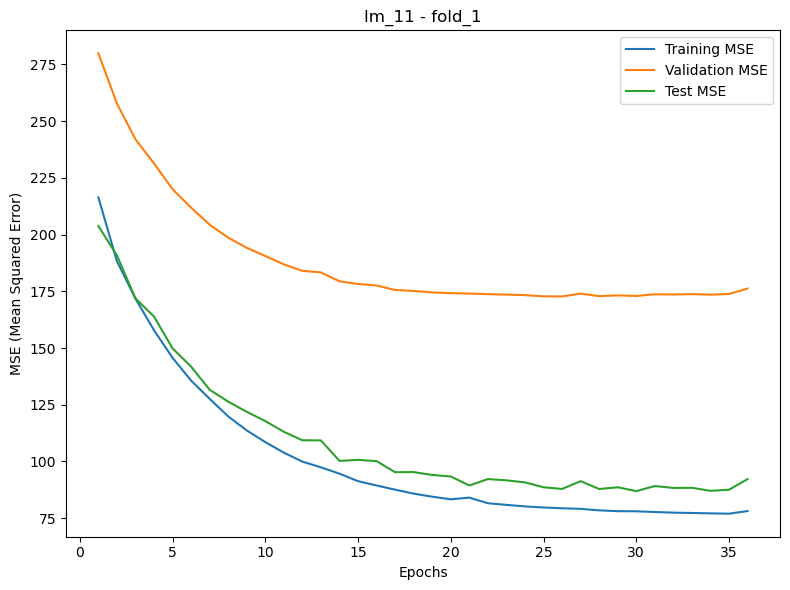

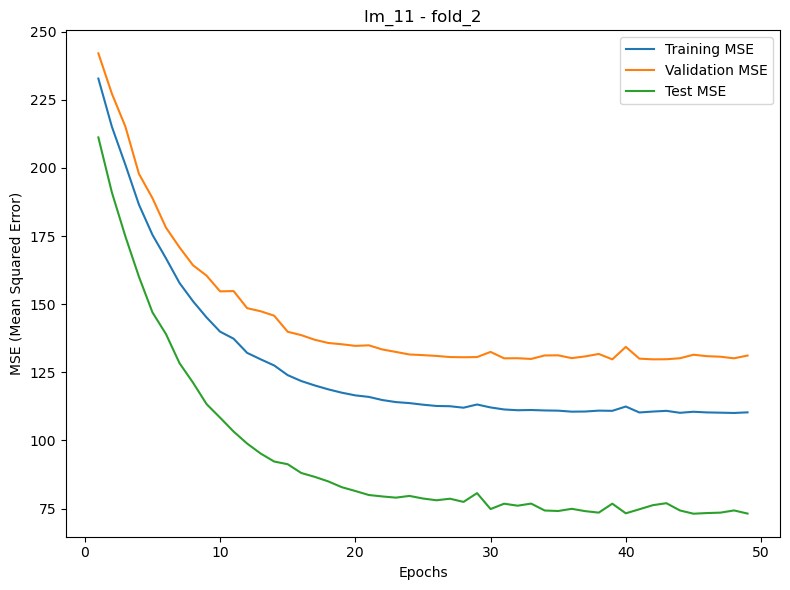

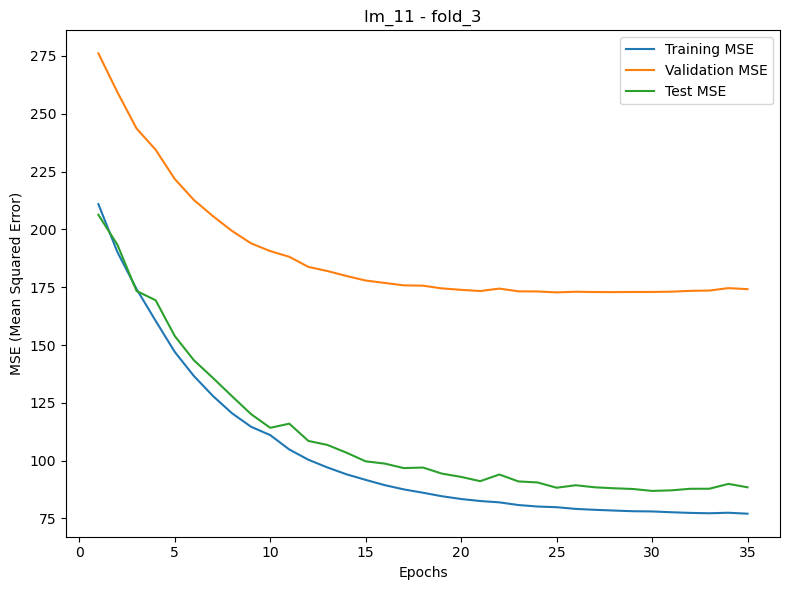

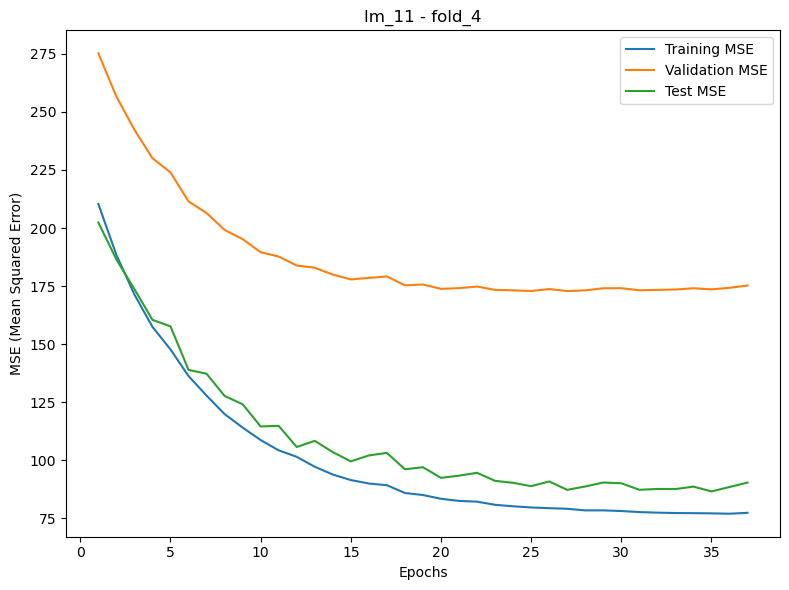

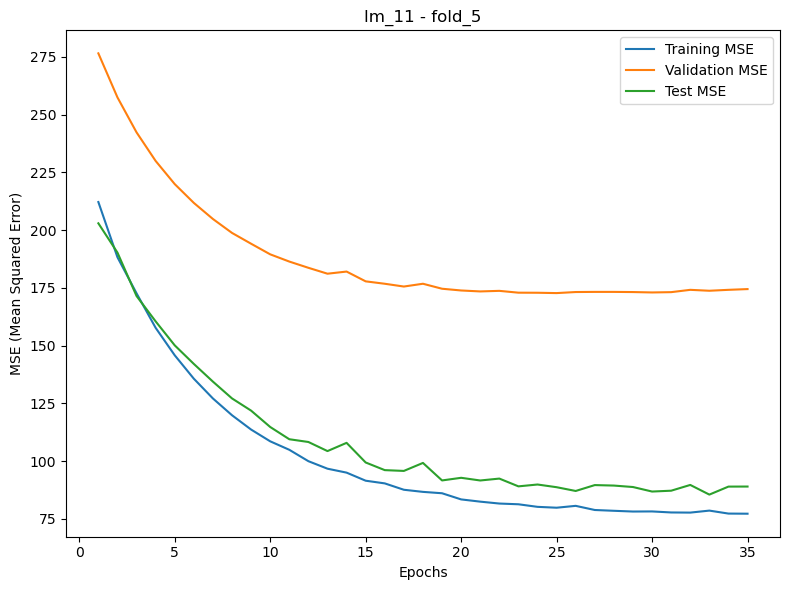

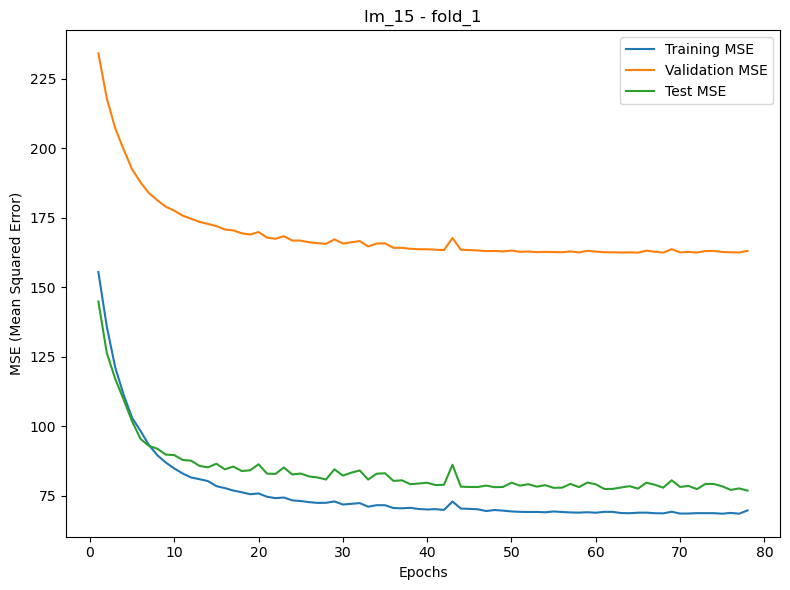

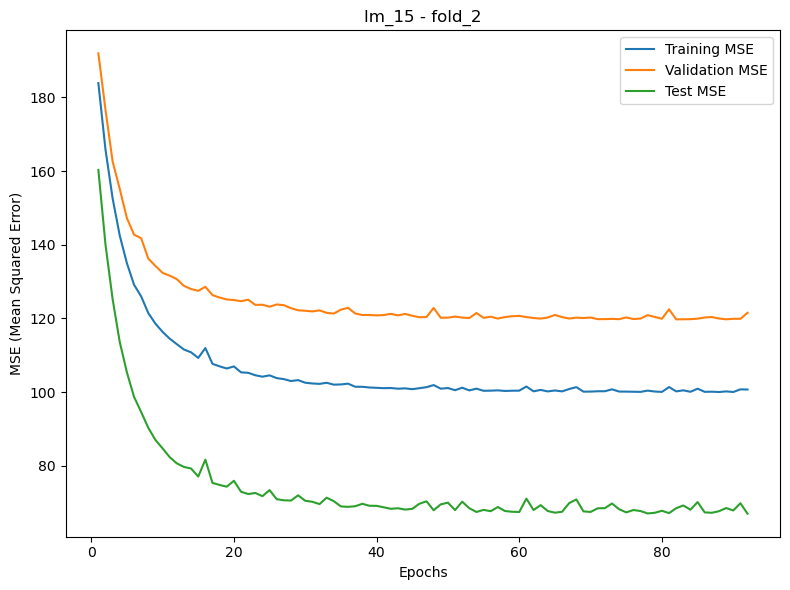

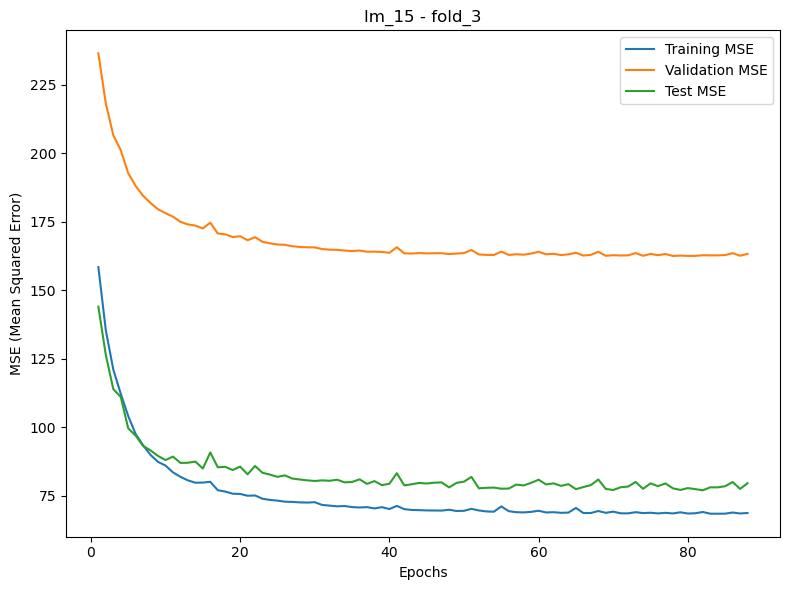

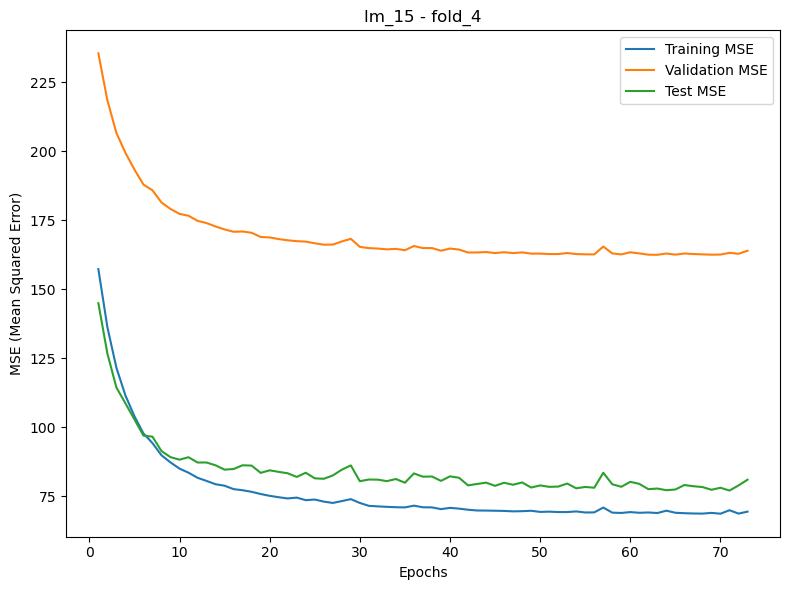

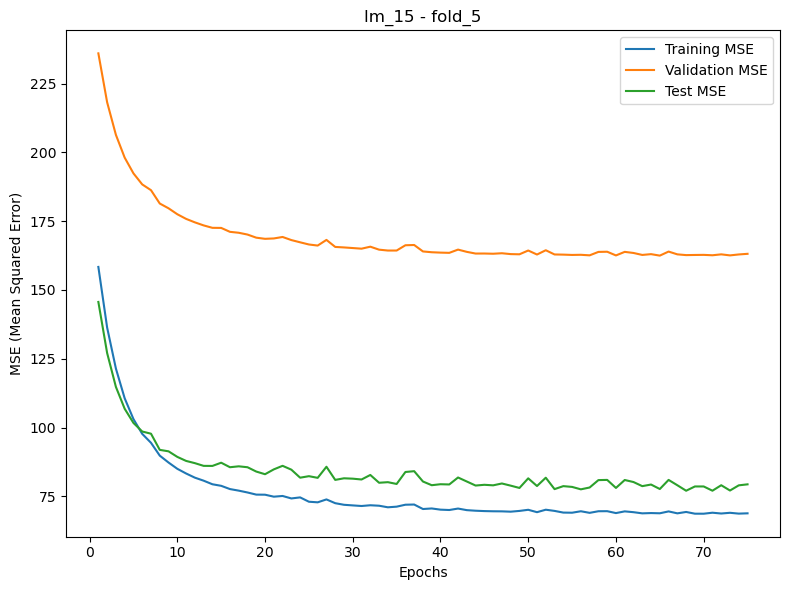

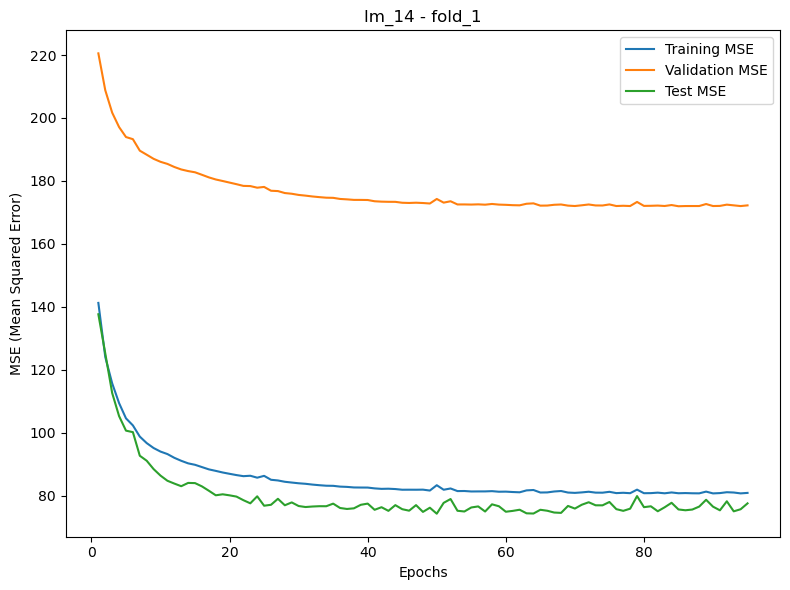

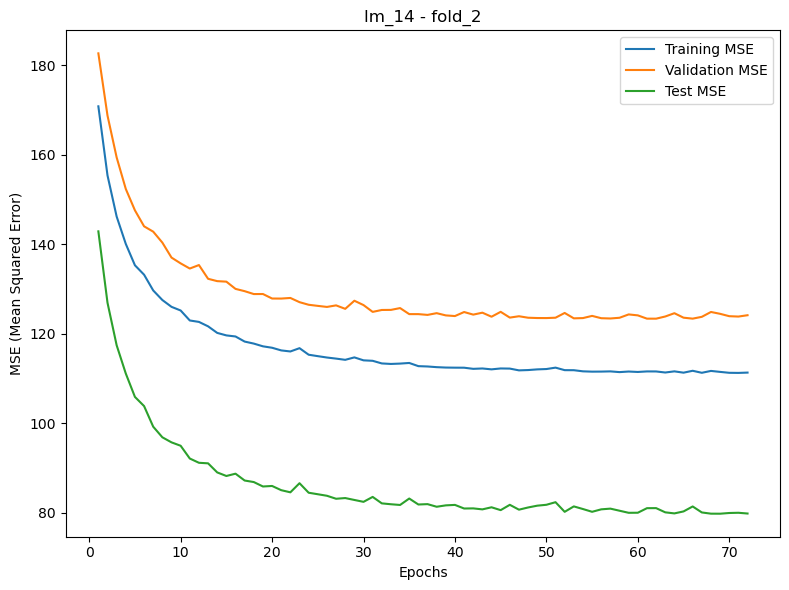

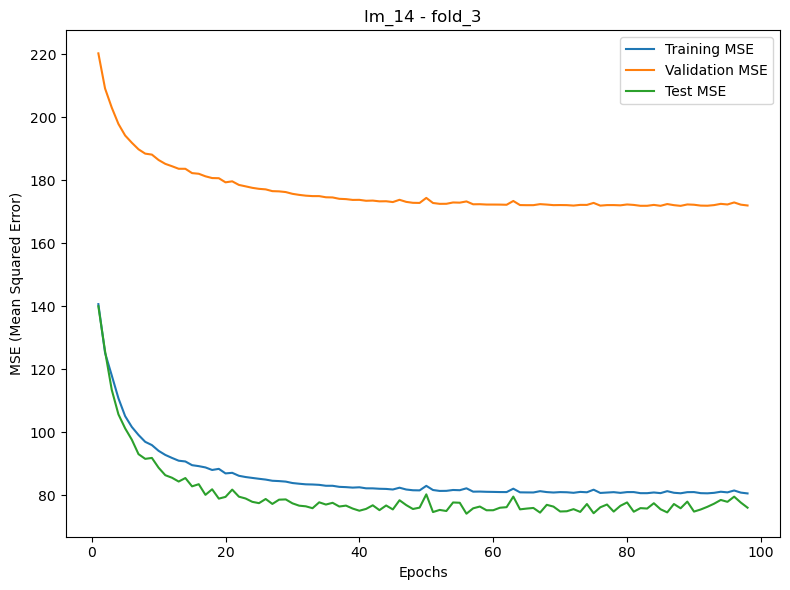

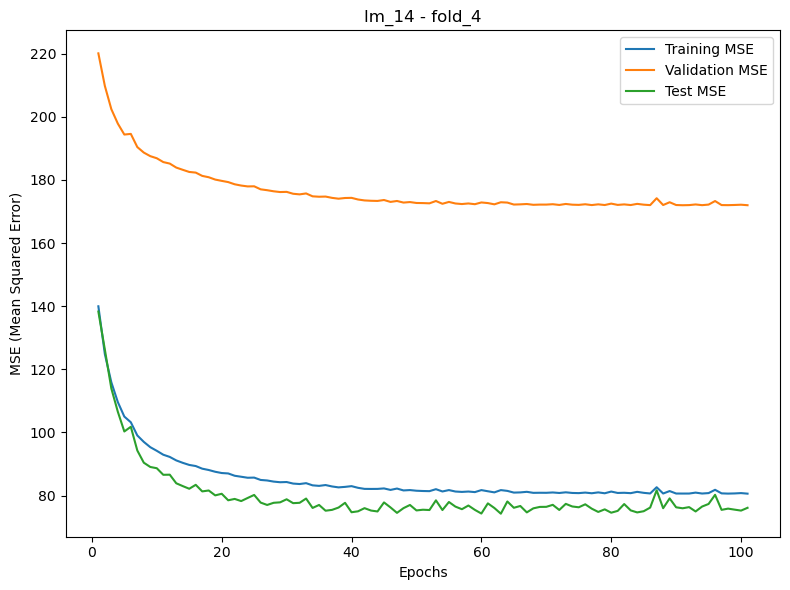

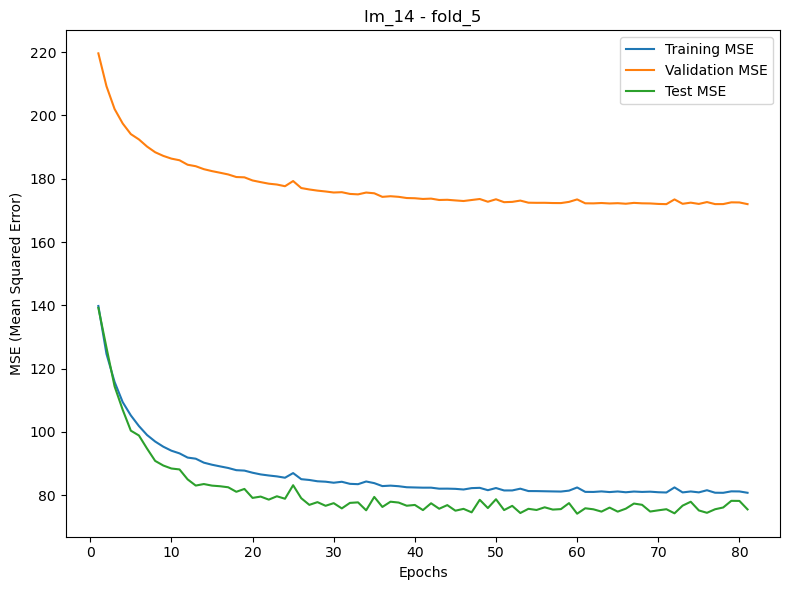

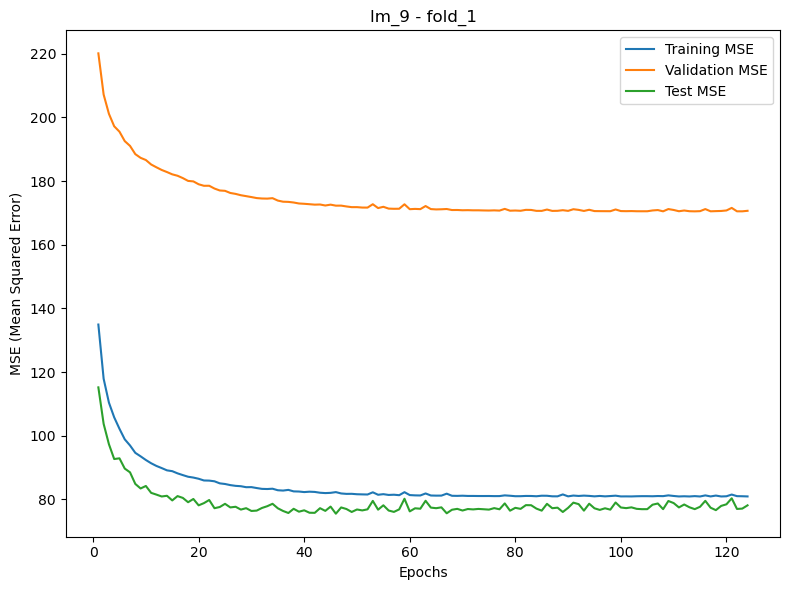

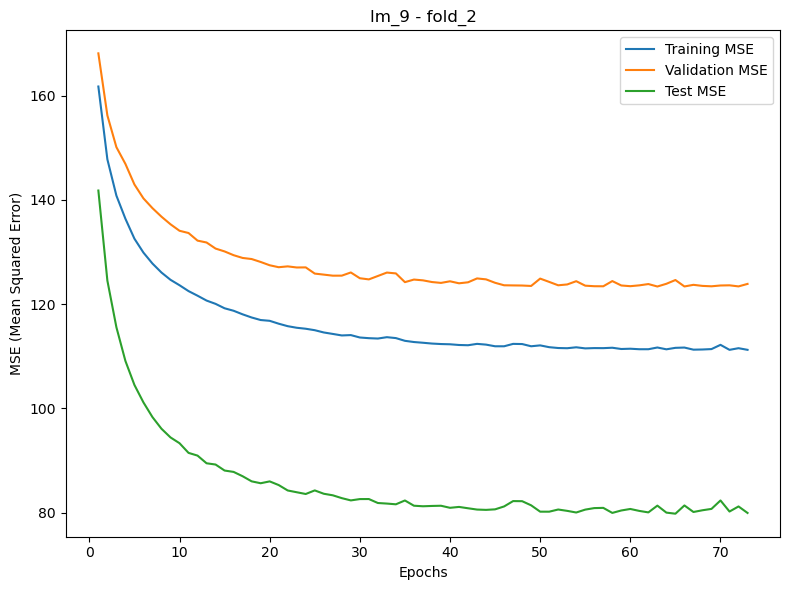

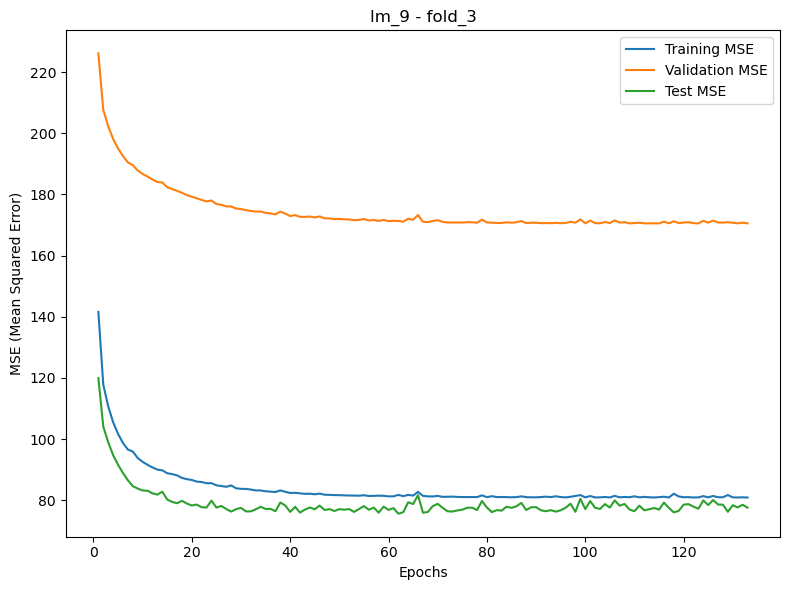

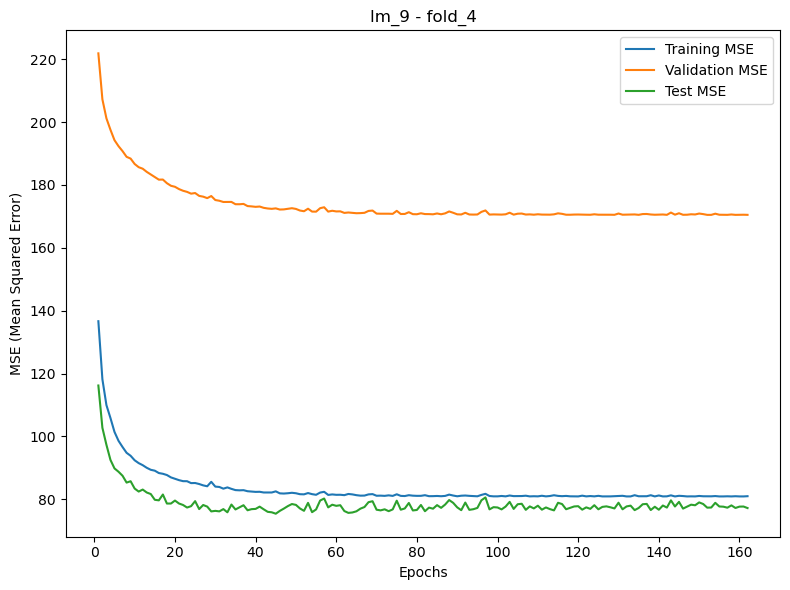

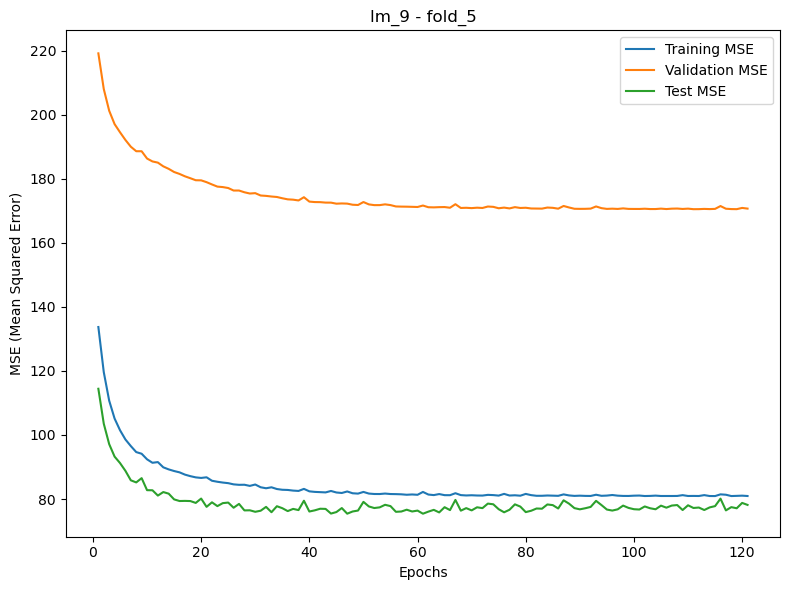

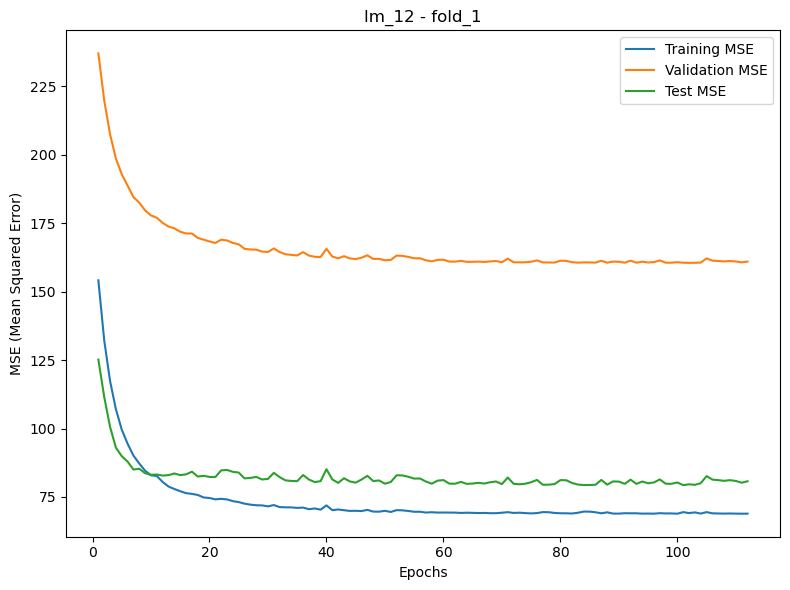

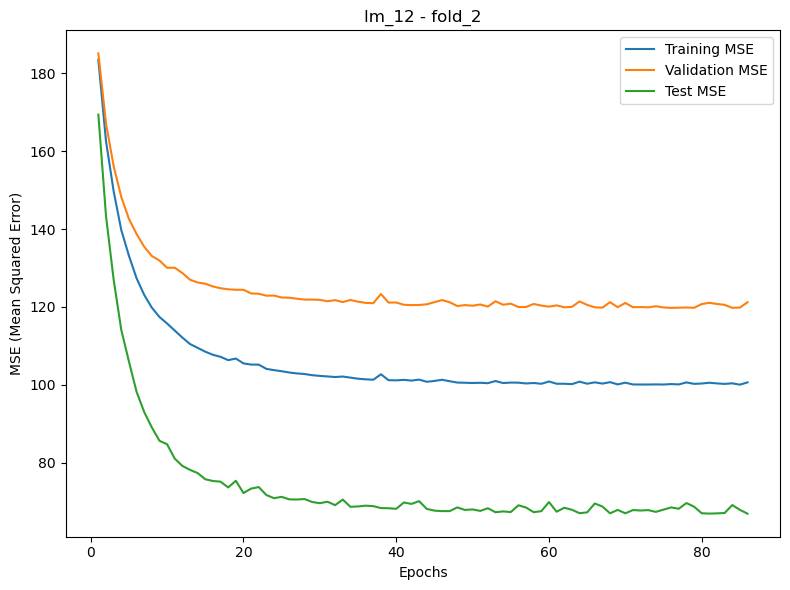

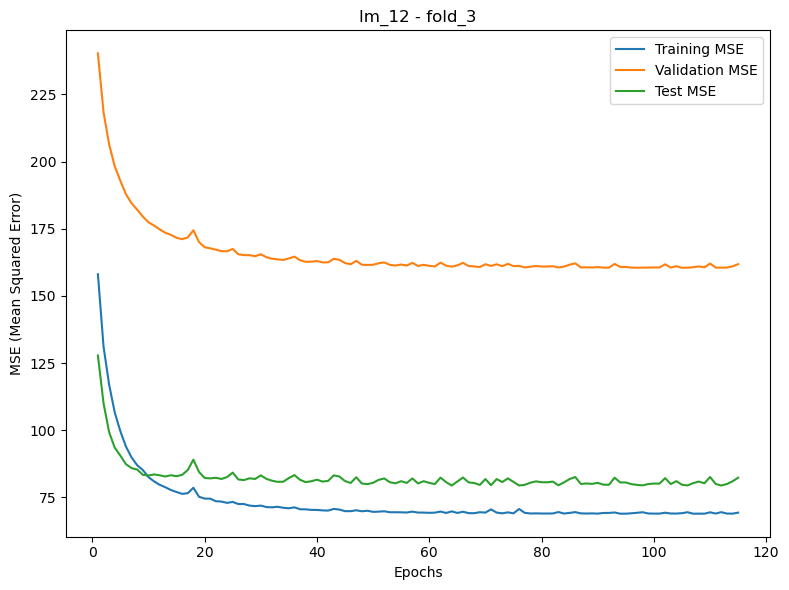

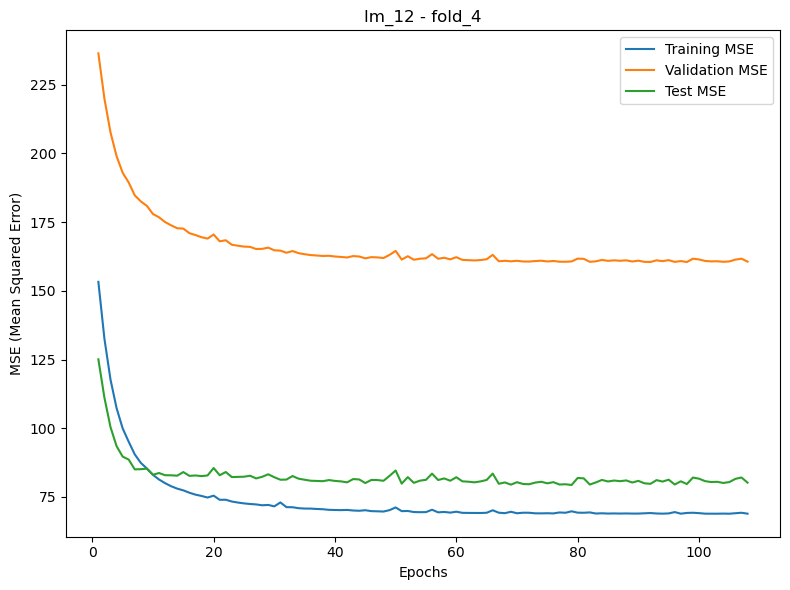

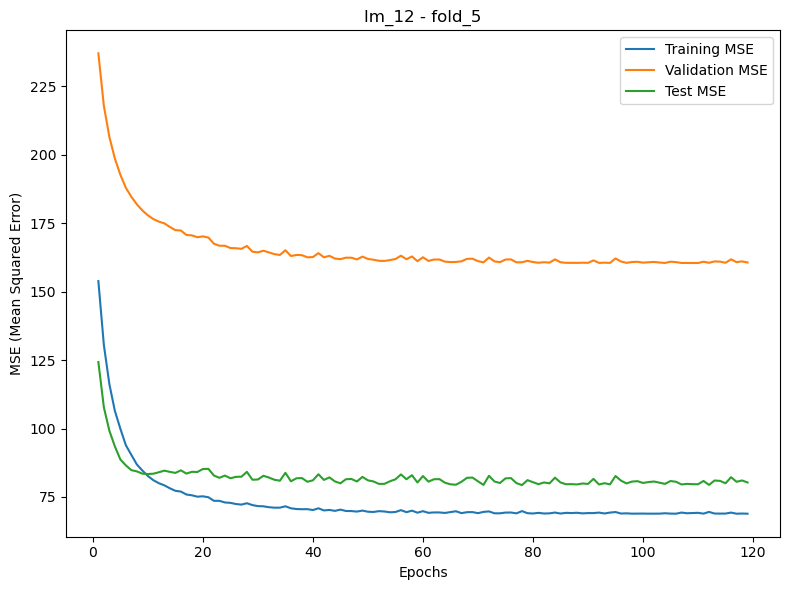

In [16]:
#plot mse vs epochs for five best models and each fold
best_models = {model for model, mse in best_five} #using best_five from previous cell which contains tuples of the five best models and average test mse
for model_key in best_models: #this loop will run through each best model and the five folds to create plots
    for fold_name, metrics in results2[model_key].items(): 
        epochs = range(1, len(metrics['train_mse']) + 1) #this uses the length of 'train_mse' as the number of epochs, range goes from 1 to that length
        plt.figure(figsize=(8,6)) #sets canvas for plots at 8 in x 6 in
        plt.plot(epochs, metrics['train_mse'], label='Training MSE') #plots training mse line
        plt.plot(epochs, metrics['val_mse'], label='Validation MSE') #plots validation mse line
        plt.plot(epochs, metrics['test_mse'], label='Test MSE') #plots test mse line
        plt.xlabel('Epochs') #x axis label
        plt.ylabel('MSE (Mean Squared Error)') #y axis label
        plt.title(f"{model_key} - {fold_name}") #title showing model number dash fold 
        plt.legend() #shows the legend in the plot
        plt.tight_layout() #prevents overlapping or cutoff of labels in plots
        plt.show() #display the plot
        